## Error Plots for JCPexample 1 

#### Steady Stokes Flow in Rotating Disk

In [1]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

#### Load Model

In [2]:
loadmodel = 'thesis1'

In [3]:
filename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + loadmodel + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

with open('../experiments/'  + loadmodel + '_errors.pickle', 'rb') as f:
    errors = pickle.load(f)

problem = importlib.import_module(".JCPexample1", package='examples')

input_dim = [problem.x_dim, problem.t_dim, problem.hyper_dim]
output_dim = problem.output_dim

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNetIncompressible':
    MyNeuralNetwork = neuralnets.ResNetIncompressible
    
nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt"))
dim_space = 2
dim_full = dim_space

numpts_r = 10
numpts_th =  60

mu = 1
L = 1  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1

### Analytic Solution
r,th = torch.meshgrid([torch.linspace(0,1, numpts_r), 
                       torch.linspace(0,2*math.pi, numpts_th)])

x1g = r*torch.cos(th)
x2g = r*torch.sin(th)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1)], dim=-1).requires_grad_(True)
integral_factor = 2*math.pi*r.detach().cpu().numpy()/(numpts_r - 1)/(numpts_th-1)

true_fun = problem.true_fun

ug = model(xg).reshape([numpts_r, numpts_th, 2])
u1_approx = ug.select(-1, 0).detach().numpy()
u2_approx = ug.select(-1, 1).detach().numpy()

speed_approx = np.sqrt(u1_approx**2 + u2_approx**2)

utrue = true_fun(xg).reshape([numpts_r, numpts_th, 2])
u1_true = utrue.select(-1,0).detach().numpy()
u2_true = utrue.select(-1,1).detach().numpy()

speed_true = np.sqrt(u1_true**2 + u2_true**2)

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()

L2_error = np.sqrt( np.sum( ((u1_approx - u1_true)**2)*integral_factor) \
                   + np.sum( ((u2_approx - u2_true)**2 )*integral_factor) )
Linf_error = np.max( [np.max( np.abs(u1_approx - u1_true)) , np.max( np.abs(u2_approx - u2_true))])

L2_norm_true = np.sqrt( np.sum( ( u1_true**2)*integral_factor ) \
                       + np.sum( ( u2_true**2)*integral_factor ) )

Linf_norm_true = np.max( [np.max( np.abs( u1_true) ), np.max( np.abs( u2_true))])

print("L2 Error = {:.4f}".format(L2_error))
print("Linf Error = {:.4f}".format(Linf_error))

print('Relative L2 Error = {:.4f}'.format(L2_error/L2_norm_true))
print('Relative Linf Error = {:.4f}'.format(Linf_error/Linf_norm_true))


L2 Error = 0.0183
Linf Error = 0.0179
Relative L2 Error = 0.0130
Relative Linf Error = 0.0179


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Plotting

In [4]:
levels = np.linspace(-1.0, 1.0, 100)
ticks  = np.linspace(-1.0, 1.0, 3)

levels_error = np.linspace(-0.1, 0.1, 100)
ticks_error = np.linspace(-0.1, 0.1, 3)

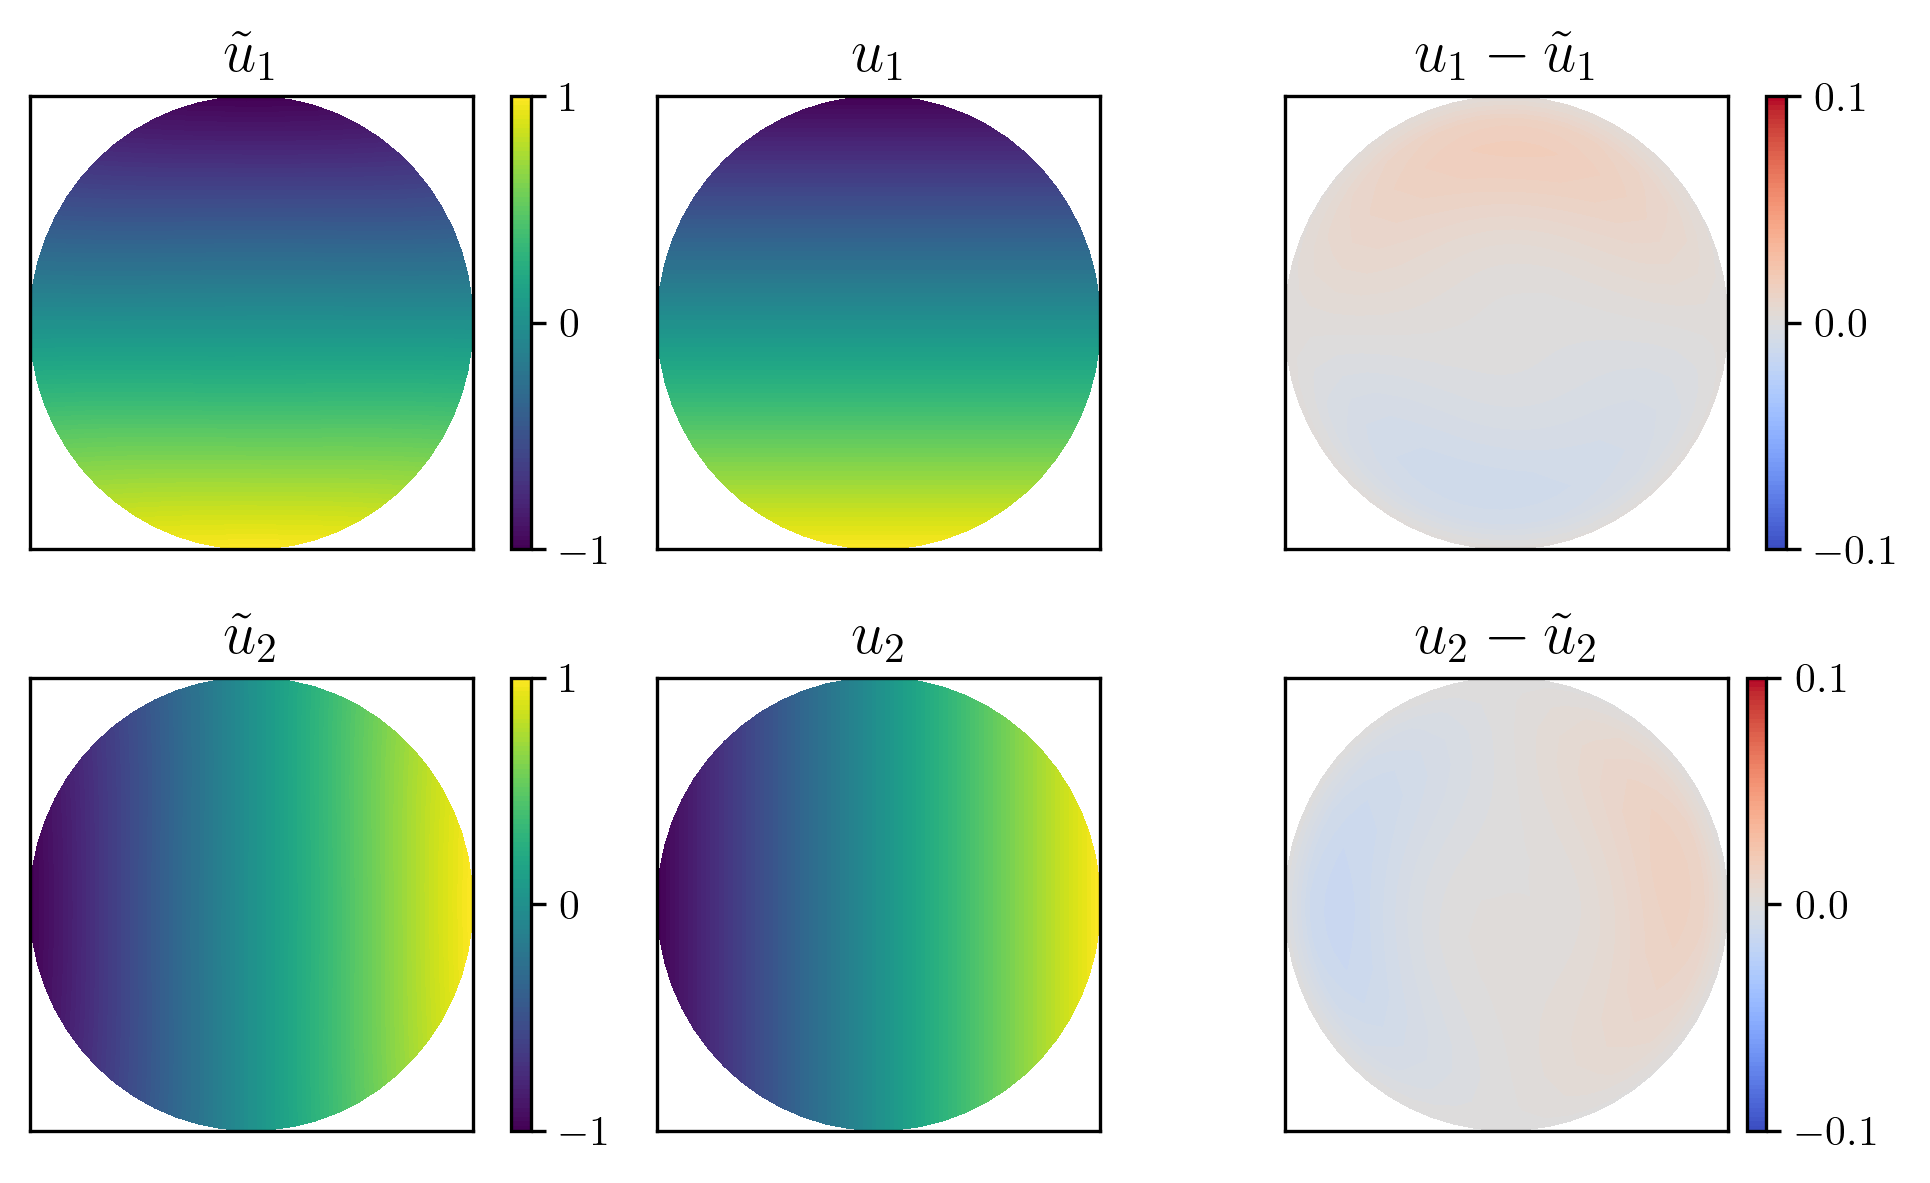

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[6.4, 4.0])
plt.tight_layout(pad=0.75)

contour0 = ax[0,0].contourf(x1plot, x2plot, u1_approx, levels = levels,
                             cmap=plt.cm.viridis)

ax[0,0].set_title(r'$\tilde{u}_1$')

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.02,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=ticks, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)


contour1 = ax[0,1].contourf(x1plot, x2plot, u1_true, levels = levels,
                 cmap=plt.cm.viridis)

ax[0,1].set_title(r'$u_1$')
ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour2 = ax[0,2].contourf(x1plot, x2plot, u1_true - u1_approx, 
                            levels = levels_error, cmap=plt.cm.coolwarm)

ax[0,2].set_title(r'$u_1 - \tilde{u}_1$')

ax[0,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[0,2].get_position().x1 + 0.02,
     ax[0,2].get_position().y0,
     0.01,
     ax[0,2].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=ticks_error, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)



contour3 = ax[1,0].contourf(x1plot, x2plot, u2_approx, levels = levels,
                 cmap=plt.cm.viridis)
ax[1,0].set_title(r'$\tilde{u}_2$')

ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar3_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.02,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar3 = plt.colorbar(contour1, ticks=ticks, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)

contour4 = ax[1,1].contourf(x1plot, x2plot, u2_true, levels = levels,
                             cmap=plt.cm.viridis)

ax[1,1].set_title(r'$u_2$')
ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)


contour5 = ax[1,2].contourf(x1plot, x2plot, u2_approx - u2_true, levels = levels_error,
                            cmap=plt.cm.coolwarm)

ax[1,2].set_title(r'$u_2 - \tilde{u}_2 $')

ax[1,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar5_param = fig.add_axes(
    [ax[1,2].get_position().x1 + 0.01,
     ax[1,2].get_position().y0,
     0.01,
     ax[1,2].get_position().height])
colorbar5 = plt.colorbar(contour5, ticks=ticks_error, cax = colorbar5_param)
colorbar5.ax.tick_params(labelsize=10)
